<b> Objective : To Predict Doctor's Consultation Fees

In [1]:
# Importing Libraries

import numpy as np 
import pandas as pd 
import unicodedata
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

from collections import Counter

import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn import metrics
from sklearn import model_selection

import gc
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
!pip install lightgbm

In [8]:
train_df=pd.read_csv('Train_data.csv')
test_df=pd.read_csv('Test.csv')

In [9]:
train_df.columns

Index(['Qualification', 'Experience', 'Rating', 'Place', 'Profile',
       'Miscellaneous_Info', 'Fees'],
      dtype='object')

In [10]:
# checking shape of dataset

train_df.shape,test_df.shape

((5961, 7), (1987, 6))

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5961 entries, 0 to 5960
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Qualification       5961 non-null   object
 1   Experience          5961 non-null   object
 2   Rating              2659 non-null   object
 3   Place               5936 non-null   object
 4   Profile             5961 non-null   object
 5   Miscellaneous_Info  3341 non-null   object
 6   Fees                5961 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 326.1+ KB


In [12]:
# Printing Unique row count for each column

print('Qualification:', train_df['Qualification'].nunique())
print('Experience:', train_df['Experience'].nunique())
print('Rating:', train_df['Rating'].nunique())
print('Place:', train_df['Place'].nunique())
print('Profile', train_df['Profile'].nunique())

Qualification: 1420
Experience: 64
Rating: 51
Place: 877
Profile 6


<b> Data Pre-processing

In [13]:
# Checking datatype in train data

ctype = train_df.dtypes.reset_index()
ctype.columns = ["Count", "Column Type"]
ctype.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,1
1,object,6


In [14]:
# check test column types

ctype = test_df.dtypes.reset_index()
ctype.columns = ["Count", "Column Type"]
ctype.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,object,6


In [15]:
# Check the Maximum and Minimum number of qualifications

# Train set
dat_train = train_df.Qualification.apply(lambda x: len(x.split(',')))
print("Maximum qualifications of a doctor in the Train dataset is {}\n".format(dat_train.max()))
print("And the qualifications is --> {}\n\n".format(train_df.Qualification[dat_train.idxmax()]))
print("Minimum qualification of a doctor in the Train dataset is {}\n".format(dat_train.min()))
print("And the qualifications is --> {}\n\n".format(train_df.Qualification[dat_train.idxmin()]))

# Test set
dat_test = test_df.Qualification.apply(lambda x: len(x.split(',')))
print("Maximum qualifications of a doctor in the Test dataset is {}\n".format(dat_test.max()))
print("And the qualifications is --> {}\n\n".format(test_df.Qualification[dat_test.idxmax()]))
print("Minimum qualification of a doctor in the Test dataset is {}\n".format(dat_test.min()))
print("And the qualifications is --> {}".format(test_df.Qualification[dat_test.idxmin()]))

Maximum qualifications of a doctor in the Train dataset is 10

And the qualifications is --> Fellowship in Oral implantlogy, Certified Advance Course In Endodontics, Certified in Orthodontics, Certification in Full Mouth Rehabilitation, Certified BPS Dentist, Certificate in Cosmetic Dentistry, Professional Implantology Training Course (PITC), Fellowship in Advanced Endoscopic Sinus Surgery, Degree in Dental Implant, Fellowship in Lasers & Cosmetology


Minimum qualification of a doctor in the Train dataset is 1

And the qualifications is --> BAMS


Maximum qualifications of a doctor in the Test dataset is 17

And the qualifications is --> BDS, PG Diploma in Conservative, Endodontics and Aesthetic Dentistry, Fellowship In Clinical Cosmetology, PG Diploma In Clinical Cosmetology (PGDCC), MBA - Hospital Management, Diploma in Cosmetic Dentistry, Fellow of Academy of General Education (FAGE), Advanced Retreatment Course in RCT, Advanced Endotontic Course On Root Canal, Certified Course in 

<b>Lets sort and check for any unusual characters in Qualification

In [16]:
sorted(test_df.Qualification[test_df.Qualification.apply(lambda x: len(x.split(','))).idxmax()].split(","))


[' Advanced Endotontic Course On Root Canal',
 ' Advanced Retreatment Course in RCT',
 ' Certificate in Cosmetic Dentistry',
 ' Certification in Prosthodontics & Periodontology',
 ' Certified Advanced Course in Wisdom Tooth Extraction',
 ' Certified Course in Oral Surgery',
 ' Diploma in Cosmetic Dentistry',
 ' Endodontics and Aesthetic Dentistry',
 ' Fellow of Academy of General Education (FAGE)',
 ' Fellowship In Clinical Cosmetology',
 ' Fellowship in Aesthetic Dentistry (FAD)',
 ' MBA - Hospital Management',
 ' MIDA',
 ' PG Diploma In Clinical Cosmetology (PGDCC)',
 ' PG Diploma in Conservative',
 ' Post Graduate Certificate in Endodontics (PGCE)',
 'BDS']

We observe that qualifications are not sorted due to leading whitespace.
We also need to remove other inconsistensies in the data like
replace comma inside bracket by hyphen
lowercase all the words
remove spaces within qualification
Lets work on them and sort the variables character wise.

In [17]:
# Define function to remove inconsistencies in the data
def sortQual(text):
    arr = re.sub(r'\([^()]+\)', lambda x: x.group().replace(",","-"), text) # to replace ',' with '-' inside brackets only
    return ','.join(sorted(arr.lower().replace(" ","").split(",")))

In [18]:
# Apply the function on the Qualification set

# Train Set
train_df.Qualification = train_df.Qualification.apply(lambda x: sortQual(x))

# Test Set
test_df.Qualification = test_df.Qualification.apply(lambda x: sortQual(x))

<b> Let's check and count total number of unique qualifications in Train and test set

In [19]:
# Define a function to create a doc of all Qualifications seprataed by ','

def doc(series):
    text = ''
    for i in series:
        text += i + ','
    return text

In [20]:
# List of top 10 unique Qualifications along with there occurence in Train Set

text = doc(train_df.Qualification)
df = pd.DataFrame.from_dict(dict(Counter(text.split(',')).most_common()), orient='index').reset_index()
df.columns=['Qualification','Count']
df.head(10)

,Qualification,Count
0,mbbs,2808
1,bds,1363
2,bams,764
3,bhms,749
4,md-dermatology,606
5,ms-ent,411
6,venereology&leprosy,297
7,md-generalmedicine,285
8,diplomainotorhinolaryngology(dlo),250
9,md-homeopathy,181


In [21]:
# List of top 10 unique Qualifications along with there occurence in Test Set

text = doc(test_df.Qualification)
df = pd.DataFrame.from_dict(dict(Counter(text.split(',')).most_common()), orient='index').reset_index()
df.columns=['Qualification','Count']
df.head(10)

,Qualification,Count
0,mbbs,980
1,bds,428
2,bhms,249
3,bams,243
4,md-dermatology,196
5,ms-ent,128
6,md-generalmedicine,99
7,venereology&leprosy,91
8,diplomainotorhinolaryngology(dlo),85
9,ddvl,67


<b>Let's assign category codes to the unique qualifications in the test dataset.</b>
We will encode qualifications only on the test data to ignore extra qualifications that are present in the train data but are not present in the test data. As the extra qualification in train data won't help model to predict fees in the test data. This is done to avoid any misfit while predicting test data after fitting on the train data due to uncommon category values.¶

In [22]:
text = doc(test_df.Qualification)
df = pd.DataFrame.from_dict(dict(Counter(text.split(',')).most_common()), orient='index').reset_index()
df.columns=['Qualification','Count']
df['code'] = df.Qualification.astype('category').cat.codes
df.head(10)


,Qualification,Count,code
0,mbbs,980,268
1,bds,428,14
2,bhms,249,16
3,bams,243,12
4,md-dermatology,196,286
5,ms-ent,128,354
6,md-generalmedicine,99,290
7,venereology&leprosy,91,425
8,diplomainotorhinolaryngology(dlo),85,112
9,ddvl,67,68


<b> Create a dictinary of Qualification with there respective codes

In [23]:
qual_dict = dict(zip(df.Qualification, df.code))


Define function to Separate multiple Qualifications into individual qualification columns

In [24]:
def qual_col(dataframe, col, col_num):
    return dataframe[col].str.split(',').str[col_num]

Split the qualifications into different columns

In [25]:
for i in range(0,dat_train.max()):
    qual = "Qual_"+ str(i+1)
    train_df[qual] = qual_col(train_df,'Qualification', i)

    
# for test set
for i in range(0,dat_test.max()):
    qual = "Qual_"+ str(i+1)
    test_df[qual] = qual_col(test_df,'Qualification', i)

In [26]:
# Select Qualification categorical columns to be encoded

column_test = ['Qual_1', 'Qual_2', 'Qual_3', 'Qual_4',
           'Qual_5', 'Qual_6', 'Qual_7', 'Qual_8', 'Qual_9', 'Qual_10', 'Qual_11',
           'Qual_12', 'Qual_13', 'Qual_14', 'Qual_15', 'Qual_16', 'Qual_17']

column_train = ['Qual_1', 'Qual_2', 'Qual_3', 'Qual_4',
           'Qual_5', 'Qual_6', 'Qual_7', 'Qual_8', 'Qual_9', 'Qual_10']

In [27]:
# Encode categorical columns for Test and Train set

for i in column_train:
    train_df.replace({i: qual_dict}, inplace=True)
    
    
for i in column_test:
    test_df.replace({i: qual_dict}, inplace=True)

Let's have a look at both dataset after encoding qualification columns

In [28]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10
0,"bhms,md-homeopathy",24 years experience,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,16,291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"bams,md-ayurvedamedicine",12 years experience,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,12,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"mbbs,ms-otorhinolaryngology",9 years experience,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300,268,359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"bams,bsc-zoology",12 years experience,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ?250 Available on...",250,12,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bams,20 years experience,100%,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<b>Lets create a new column depicting the number of qualifications per doctor.

In [29]:
train_df['Qual_count'] = train_df.Qualification.apply(lambda x: len(x.split(',')))
test_df['Qual_count'] = test_df.Qualification.apply(lambda x: len(x.split(',')))

Now we will convert experience into integer value

In [30]:
# Train set
train_df['years_exp'] = train_df['Experience'].str.slice(stop=2).astype(int)

# Test set
test_df['years_exp'] = test_df['Experience'].str.slice(stop=2).astype(int)

In [31]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,Qual_count,years_exp
0,"bhms,md-homeopathy",24 years experience,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,16,291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,24
1,"bams,md-ayurvedamedicine",12 years experience,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,12,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12
2,"mbbs,ms-otorhinolaryngology",9 years experience,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300,268,359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,9
3,"bams,bsc-zoology",12 years experience,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ?250 Available on...",250,12,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12
4,bams,20 years experience,100%,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20


We have to fill missing ratings with NaN values as 0% and convert the string type into integer to fetch actual value

In [33]:
# Train set
train_df['Rating'].fillna('0%',inplace = True)
train_df['Rating'] = train_df['Rating'].str.slice(stop=-1).astype(int)

# Test set
test_df['Rating'].fillna('0%',inplace = True)
test_df['Rating'] = test_df['Rating'].str.slice(stop=-1).astype(int)

In [34]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,Qual_count,years_exp
0,"bhms,md-homeopathy",24 years experience,100,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,16,291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,24
1,"bams,md-ayurvedamedicine",12 years experience,98,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,12,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12
2,"mbbs,ms-otorhinolaryngology",9 years experience,0,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300,268,359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,9
3,"bams,bsc-zoology",12 years experience,0,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ?250 Available on...",250,12,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12
4,bams,20 years experience,100,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20


Lets cleanup inconsistencies of the place variable to fetch out City and localities¶

In [35]:
train_df.Place = train_df.Place.apply(lambda x: ','.join(str(x).lower().replace(" ","").split(",")))
test_df.Place = train_df.Place.apply(lambda x: ','.join(str(x).lower().replace(" ","").split(",")))

Separate City and Locality from Place variable

In [36]:
# Train Set
train_df['City'] = train_df['Place'].apply(lambda x: str(x).replace(' ','').split(',')[-1])
train_df['Locality'] = train_df['Place'].apply(lambda x: str(x).rsplit(',', 1)[0])


# Test Set
test_df['City'] = test_df['Place'].apply(lambda x: str(x).replace(' ','').split(',')[-1])
test_df['Locality'] = test_df['Place'].apply(lambda x: str(x).rsplit(',', 1)[0])

In [37]:
# Lets Check Unique Cities in test set

test_df.City.value_counts()

delhi                 406
bangalore             403
mumbai                401
hyderabad             319
chennai               290
coimbatore             78
ernakulam              52
thiruvananthapuram     30
nan                     8
Name: City, dtype: int64

In [38]:
# Lets Check Unique Cities in train set

train_df.City.value_counts()

bangalore             1258
mumbai                1219
delhi                 1185
hyderabad              951
chennai                855
coimbatore             228
ernakulam              153
thiruvananthapuram      86
nan                     25
e                        1
Name: City, dtype: int64

Let's check that final record with e as the city name

In [39]:
train_df[train_df.City == 'e']


,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,...,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,Qual_count,years_exp,City,Locality
3980,bds,23 years experience,0,e,Dentist,NaN,250,14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,23,e,e


Clearly its a one off record. Lets mark the Place, city and locality as missing instead of deleting the record

In [40]:
train_df.loc[3980, 'Place'] = np.nan
train_df.loc[3980, 'City'] = np.nan
train_df.loc[3980, 'Locality'] = np.nan

Since the number of Cities are less, We can dummify the city names. Lets do it

In [42]:
# Define function to dummify feature

def get_dummies(dataframe,feature_name):
  dummy = pd.get_dummies(dataframe[feature_name], prefix=feature_name)
  dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
  return pd.concat([dataframe,dummy], axis = 1)


In [43]:
train_df = get_dummies(train_df, 'City')
test_df = get_dummies(test_df, 'City')

In [44]:
# Checkout dataframe after dummification of City

train_df.head()


,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,...,City,Locality,City_chennai,City_coimbatore,City_delhi,City_ernakulam,City_hyderabad,City_mumbai,City_nan,City_thiruvananthapuram
0,"bhms,md-homeopathy",24 years experience,100,"kakkanad,ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,16,291,NaN,...,ernakulam,kakkanad,0,0,0,1,0,0,0,0
1,"bams,md-ayurvedamedicine",12 years experience,98,"whitefield,bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,12,280,NaN,...,bangalore,whitefield,0,0,0,0,0,0,0,0
2,"mbbs,ms-otorhinolaryngology",9 years experience,0,"mathikere-bel,bangalore",ENT Specialist,NaN,300,268,359,NaN,...,bangalore,mathikere-bel,0,0,0,0,0,0,0,0
3,"bams,bsc-zoology",12 years experience,0,"bannerghattaroad,bangalore",Ayurveda,"Bannerghatta Road, Bangalore ?250 Available on...",250,12,21,NaN,...,bangalore,bannerghattaroad,0,0,0,0,0,0,0,0
4,bams,20 years experience,100,"keelkattalai,chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,12,NaN,NaN,...,chennai,keelkattalai,1,0,0,0,0,0,0,0


Let's now check the unique Profile's in the dataset

In [45]:
train_df.Profile.value_counts()


Dentist             1397
General Medicine    1173
Dermatologists      1034
Homeopath            843
Ayurveda             786
ENT Specialist       728
Name: Profile, dtype: int64

Let's prune up the profile variable and dummify them in both the datasets

In [46]:
train_df.Profile = train_df.Profile.apply(lambda x: str(x).lower().replace(" ",""))
test_df.Profile = train_df.Profile.apply(lambda x: str(x).lower().replace(" ",""))

In [47]:
train_df = get_dummies(train_df, 'Profile')
test_df = get_dummies(test_df, 'Profile')

Let's checkout the dataset after dummification of profile variable

In [48]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,...,City_ernakulam,City_hyderabad,City_mumbai,City_nan,City_thiruvananthapuram,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath
0,"bhms,md-homeopathy",24 years experience,100,"kakkanad,ernakulam",homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,16,291,NaN,...,1,0,0,0,0,0,0,0,0,1
1,"bams,md-ayurvedamedicine",12 years experience,98,"whitefield,bangalore",ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,12,280,NaN,...,0,0,0,0,0,0,0,0,0,0
2,"mbbs,ms-otorhinolaryngology",9 years experience,0,"mathikere-bel,bangalore",entspecialist,NaN,300,268,359,NaN,...,0,0,0,0,0,0,0,1,0,0
3,"bams,bsc-zoology",12 years experience,0,"bannerghattaroad,bangalore",ayurveda,"Bannerghatta Road, Bangalore ?250 Available on...",250,12,21,NaN,...,0,0,0,0,0,0,0,0,0,0
4,bams,20 years experience,100,"keelkattalai,chennai",ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,12,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# train_df.Locality.value_counts()
# List of top 10 Localities along with there occurence in Train Set
train_df['Locality'] = train_df['Locality'].apply(str) # Convert int64 dtype to str type first
text = doc(train_df.Locality)
df = pd.DataFrame.from_dict(dict(Counter(text.split(',')).most_common()), orient='index').reset_index()
df.columns=['Locality','Count']
df.head(10)

,Locality,Count
0,hsrlayout,75
1,andheriwest,70
2,dwarka,68
3,banjarahills,64
4,mulundwest,54
5,borivaliwest,52
6,kandivaliwest,50
7,indiranagar,48
8,whitefield,47
9,malleswaram,47


In [51]:
# List of top 10 unique Localities along with there occurence in Test Set
test_df['Locality'] = test_df['Locality'].apply(str) # Convert int64 dtype to str type first
text = doc(test_df.Locality)
df = pd.DataFrame.from_dict(dict(Counter(text.split(',')).most_common()), orient='index').reset_index()
df.columns=['Locality','Count']
df.head(10)

,Locality,Count
0,andheriwest,25
1,borivaliwest,23
2,dwarka,23
3,malleswaram,21
4,hsrlayout,20
5,ghatkopareast,20
6,whitefield,19
7,indiranagar,19
8,kandivaliwest,18
9,adyar,16


Let's encode Locality feature of the test set and then merge into train set

In [52]:
# Define function to label encode the selected categorical variable for modeling

def encode(data):
    return data.astype('category').cat.codes

In [53]:
# Encode Locality column of test data

columns = ['Locality']

for i in columns:
    col = i+"_code"
    test_df[col] = encode(test_df[i])

In [54]:
# Check test dataset after encoding locality
test_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Qual_1,Qual_2,Qual_3,Qual_4,...,City_hyderabad,City_mumbai,City_nan,City_thiruvananthapuram,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath,Locality_code
0,mbbs,35 years experience,0,"kakkanad,ernakulam",homeopath,NaN,268,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,207
1,"diplomainotorhinolaryngology(dlo),mbbs",31 years experience,0,"whitefield,bangalore",ayurveda,NaN,112,268.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,587
2,"ddvl,mbbs",40 years experience,70,"mathikere-bel,bangalore",entspecialist,"70% 4 Feedback KK Nagar, Chennai",68,268.0,NaN,NaN,...,0,0,0,0,0,0,1,0,0,308
3,bams,0 years experience,0,"bannerghattaroad,bangalore",ayurveda,NaN,12,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,50
4,"bds,mds-conservativedentistry&endodontics",16 years experience,100,"keelkattalai,chennai",ayurveda,General Dentistry Conservative Dentistry Cosme...,14,315.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,234


In [55]:
# Create unique lists of [variable, variable code] combination and drop duplicate pairs.

df_test_merge = test_df[['Locality','Locality_code']].drop_duplicates()


In [56]:
# Pull the respective encoded variables list in the train data (Using a left join) to avoid any merging issue.

train_df = pd.merge(train_df,df_test_merge[['Locality','Locality_code']],on='Locality', how='left')

In [57]:
# Train set after merging encoded Locality

train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,...,City_hyderabad,City_mumbai,City_nan,City_thiruvananthapuram,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath,Locality_code
0,"bhms,md-homeopathy",24 years experience,100,"kakkanad,ernakulam",homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,16,291,NaN,...,0,0,0,0,0,0,0,0,1,207.0
1,"bams,md-ayurvedamedicine",12 years experience,98,"whitefield,bangalore",ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,12,280,NaN,...,0,0,0,0,0,0,0,0,0,587.0
2,"mbbs,ms-otorhinolaryngology",9 years experience,0,"mathikere-bel,bangalore",entspecialist,NaN,300,268,359,NaN,...,0,0,0,0,0,0,1,0,0,308.0
3,"bams,bsc-zoology",12 years experience,0,"bannerghattaroad,bangalore",ayurveda,"Bannerghatta Road, Bangalore ?250 Available on...",250,12,21,NaN,...,0,0,0,0,0,0,0,0,0,50.0
4,bams,20 years experience,100,"keelkattalai,chennai",ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,12,NaN,NaN,...,0,0,0,0,0,0,0,0,0,234.0


Coming to the messy column i.e Miscellaneous_Info Lets make the most out of this

In [58]:
list(train_df.Miscellaneous_Info[0:10])

['100% 16 Feedback Kakkanad, Ernakulam',
 '98% 76 Feedback Whitefield, Bangalore',
 nan,
 'Bannerghatta Road, Bangalore ?250 Available on Sun, 10 Feb',
 '100% 4 Feedback Keelkattalai, Chennai',
 nan,
 nan,
 'Dental Fillings Crowns and Bridges Fixing Impaction / Impacted Tooth Extraction',
 nan,
 nan]

It can be observed that:

Few rows have NaN values
Few rows give only the profile related info along with the fees of the Doctor ;)
Other rows give info about the doctors rating followed by number of people rated then the address
There are lot of commas in the value, Lets remove them to avoid any discrepancy


In [59]:
train_df.Miscellaneous_Info = train_df.Miscellaneous_Info.str.replace(",","")
test_df.Miscellaneous_Info = test_df.Miscellaneous_Info.str.replace(",","")

Now let's convert the Indian Rupee symbol to readable INR String

In [60]:
# Train set
train_df.Miscellaneous_Info = train_df.Miscellaneous_Info.str.replace(unicodedata.lookup('Indian Rupee Sign'), 'INR ')

# Test set
test_df.Miscellaneous_Info = test_df.Miscellaneous_Info.str.replace(unicodedata.lookup('Indian Rupee Sign'), 'INR ')

In [61]:
list(train_df.Miscellaneous_Info[0:10])

['100% 16 Feedback Kakkanad Ernakulam',
 '98% 76 Feedback Whitefield Bangalore',
 nan,
 'Bannerghatta Road Bangalore ?250 Available on Sun 10 Feb',
 '100% 4 Feedback Keelkattalai Chennai',
 nan,
 nan,
 'Dental Fillings Crowns and Bridges Fixing Impaction / Impacted Tooth Extraction',
 nan,
 nan]

In [62]:
# Define function to return the Feedback numbers

def find_feedback(data):
    result = re.search(r' (.*?) Feedback',data)
    if result:
        return int(result.group(1))
    else:
        return 0

In [63]:
# Fetch out the feedback numbers in different records. 

# Train set
train_df['feedack_num'] = train_df.Miscellaneous_Info.apply(lambda x: find_feedback(x) if '%' in str(x) else 0)

# Test set
test_df['feedack_num'] = test_df.Miscellaneous_Info.apply(lambda x: find_feedback(x) if '%' in str(x) else 0)

In [64]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,...,City_mumbai,City_nan,City_thiruvananthapuram,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath,Locality_code,feedack_num
0,"bhms,md-homeopathy",24 years experience,100,"kakkanad,ernakulam",homeopath,100% 16 Feedback Kakkanad Ernakulam,100,16,291,NaN,...,0,0,0,0,0,0,0,1,207.0,16
1,"bams,md-ayurvedamedicine",12 years experience,98,"whitefield,bangalore",ayurveda,98% 76 Feedback Whitefield Bangalore,350,12,280,NaN,...,0,0,0,0,0,0,0,0,587.0,76
2,"mbbs,ms-otorhinolaryngology",9 years experience,0,"mathikere-bel,bangalore",entspecialist,NaN,300,268,359,NaN,...,0,0,0,0,0,1,0,0,308.0,0
3,"bams,bsc-zoology",12 years experience,0,"bannerghattaroad,bangalore",ayurveda,Bannerghatta Road Bangalore ?250 Available on ...,250,12,21,NaN,...,0,0,0,0,0,0,0,0,50.0,0
4,bams,20 years experience,100,"keelkattalai,chennai",ayurveda,100% 4 Feedback Keelkattalai Chennai,250,12,NaN,NaN,...,0,0,0,0,0,0,0,0,234.0,4


In [67]:
# Define function to return the Fees Value

def find_fees(data):
    result = re.search(r'INR (\d*)',data)
    if result:
        return int(result.group(1))
    else:
        return 0

In [68]:
# Fetch out the Fees value in different records. 

# Train set
train_df['fees_val'] = train_df.Miscellaneous_Info.apply(lambda x: find_fees(x) if 'INR' in str(x) else 0)

# Test set
test_df['fees_val'] = test_df.Miscellaneous_Info.apply(lambda x: find_fees(x) if 'INR' in str(x) else 0)

In [69]:
train_df.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,...,City_nan,City_thiruvananthapuram,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath,Locality_code,feedack_num,fees_val
0,"bhms,md-homeopathy",24 years experience,100,"kakkanad,ernakulam",homeopath,100% 16 Feedback Kakkanad Ernakulam,100,16,291,NaN,...,0,0,0,0,0,0,1,207.0,16,0
1,"bams,md-ayurvedamedicine",12 years experience,98,"whitefield,bangalore",ayurveda,98% 76 Feedback Whitefield Bangalore,350,12,280,NaN,...,0,0,0,0,0,0,0,587.0,76,0
2,"mbbs,ms-otorhinolaryngology",9 years experience,0,"mathikere-bel,bangalore",entspecialist,NaN,300,268,359,NaN,...,0,0,0,0,1,0,0,308.0,0,0
3,"bams,bsc-zoology",12 years experience,0,"bannerghattaroad,bangalore",ayurveda,Bannerghatta Road Bangalore ?250 Available on ...,250,12,21,NaN,...,0,0,0,0,0,0,0,50.0,0,0
4,bams,20 years experience,100,"keelkattalai,chennai",ayurveda,100% 4 Feedback Keelkattalai Chennai,250,12,NaN,NaN,...,0,0,0,0,0,0,0,234.0,4,0


Let's check the Fees Distribution in Train Dataset

In [70]:
train_df.Fees.value_counts().reset_index().sort_values(by='index')

,index,Fees
30,5,1
21,10,2
39,20,1
20,30,4
25,40,2
11,50,81
19,60,11
17,70,18
18,80,12
0,100,1306


It is observable that many records have Fees mentioned as less than 50. Lets check those records.

In [71]:
train_df[train_df.Fees < 50]

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,...,City_nan,City_thiruvananthapuram,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath,Locality_code,feedack_num,fees_val
1316,bams,4 years experience,0,"worli,mumbai",ayurveda,NaN,10,12,NaN,NaN,...,0,0,0,0,0,0,0,589.0,0,0
1930,bds,6 years experience,0,"tvmedicalcollege,thiruvananthapuram",dentist,NaN,5,14,NaN,NaN,...,0,1,1,0,0,0,0,538.0,0,0
2248,"bhms,certificateinchildhealth(cch),cgo",22 years experience,0,"kandivaliwest,mumbai",homeopath,NaN,40,16,34,58,...,0,0,0,0,0,0,1,221.0,0,0
2459,bams,37 years experience,0,"bandraeast,mumbai",ayurveda,NaN,40,12,NaN,NaN,...,0,0,0,0,0,0,0,46.0,0,0
2563,md-ayurvedamedicine,35 years experience,0,"marathahalli,bangalore",ayurveda,NaN,30,280,NaN,NaN,...,0,0,0,0,0,0,0,306.0,0,0
3303,bds,3 years experience,0,"perumbavoor,ernakulam",dentist,NaN,10,14,NaN,NaN,...,0,0,1,0,0,0,0,407.0,0,0
3499,bams,45 years experience,0,"bhandupwest,mumbai",ayurveda,NaN,30,12,NaN,NaN,...,0,0,0,0,0,0,0,61.0,0,0
4290,bams,15 years experience,0,"secunderabad,hyderabad",ayurveda,NaN,30,12,NaN,NaN,...,0,0,0,0,0,0,0,473.0,0,0
4748,"mbbs,md-generalmedicine",44 years experience,0,"secunderabad,hyderabad",generalmedicine,NaN,20,268,290,NaN,...,0,0,0,0,0,1,0,473.0,0,0
5703,bams,9 years experience,0,"goregaoneast,mumbai",ayurveda,NaN,30,12,NaN,NaN,...,0,0,0,0,0,0,0,146.0,0,0


It can be seen that there are records where years of experience is greater than 10 or 20 but the Fees is less than 50. Whereas some of the records have less than 1 years of experience even then the fees is more than 50. We cannot deny the fact that different qualification and profile demands different fees. But there are always exception in terms of charity or other services, so therefore we can ignore thee records and let them remain intact for the sake of model training

Lets check the years of experience distribution

In [72]:
train_df.years_exp.describe()

count    5961.000000
mean       17.303976
std        11.142798
min         0.000000
25%         9.000000
50%        14.000000
75%        23.000000
max        66.000000
Name: years_exp, dtype: float64

We can observe that min exp is being shown as 0 and max is 66. Both of them seems to be unusual. Lets check the experience distribution in Test set

In [74]:
test_df.years_exp.describe()

count    1987.000000
mean       17.874685
std        11.366764
min         0.000000
25%         9.000000
50%        15.000000
75%        24.000000
max        65.000000
Name: years_exp, dtype: float64

It looks like almost similar distribution in the test set from the experience perspective. So we cannot ignore the records with minimum and maximum years of experience in the Train set. Let's check the records with 0 years of experience in the Train set

In [75]:
train_df[train_df.years_exp == 0]

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Qual_1,Qual_2,Qual_3,...,City_nan,City_thiruvananthapuram,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath,Locality_code,feedack_num,fees_val
91,getinspiredbyremarkablestoriesofpeoplelikeyou,0 years experience,0,nan,dermatologists,NaN,100,241,NaN,NaN,...,1,0,0,1,0,0,0,350.0,0,0
168,bams,0 years experience,0,"bhandupwest,mumbai",ayurveda,NaN,100,12,NaN,NaN,...,0,0,0,0,0,0,0,61.0,0,0
380,"diplomainotorhinolaryngology(dlo),mbbs,ms-ent",0 years experience,0,"marinelines,mumbai",entspecialist,NaN,100,112,268,354,...,0,0,0,0,1,0,0,307.0,0,0
383,bds,0 years experience,0,"chromepet,chennai",dentist,Dental Fillings Dental Crowns General Dentistry,100,14,NaN,NaN,...,0,0,1,0,0,0,0,96.0,0,0
409,bds,0 years experience,0,"ganapathy,coimbatore",dentist,NaN,100,14,NaN,NaN,...,0,0,1,0,0,0,0,139.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5533,bhms,0 years experience,0,"kaggadasapura,bangalore",homeopath,Skin Allergy Treatment Chronic Skin Allergy Wr...,250,16,NaN,NaN,...,0,0,0,0,0,0,1,205.0,0,0
5551,getinspiredbyremarkablestoriesofpeoplelikeyou,0 years experience,0,nan,dermatologists,NaN,100,241,NaN,NaN,...,1,0,0,1,0,0,0,350.0,0,0
5723,getinspiredbyremarkablestoriesofpeoplelikeyou,0 years experience,0,nan,dermatologists,NaN,100,241,NaN,NaN,...,1,0,0,1,0,0,0,350.0,0,0
5821,"mbbs,md-internalmedicine",0 years experience,0,"crpark,delhi",generalmedicine,NaN,500,268,293,NaN,...,0,0,0,0,0,1,0,103.0,0,0


While most of the records seems legit, but there are some recods with some unusual qualification text as getinspiredbyremarkablestoriesofpeoplelikeyou and all of them has Profile marked as Dermatologists with the Fees value as 100. Lets check whether test set also contains such records?

In [76]:
test_df[test_df.Qualification.str.contains('getinspiredbyremarkablestoriesofpeoplelikeyou')]

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Qual_1,Qual_2,Qual_3,Qual_4,...,City_nan,City_thiruvananthapuram,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath,Locality_code,feedack_num,fees_val
381,getinspiredbyremarkablestoriesofpeoplelikeyou,0 years experience,0,"omrroad,chennai",ayurveda,NaN,241,NaN,NaN,NaN,...,0,0,0,0,0,0,0,373,0,0
1494,getinspiredbyremarkablestoriesofpeoplelikeyou,0 years experience,0,"jpnagar3phase,bangalore",ayurveda,NaN,241,NaN,NaN,NaN,...,0,0,0,0,0,0,0,197,0,0
1644,getinspiredbyremarkablestoriesofpeoplelikeyou,0 years experience,0,"tuglakabad,delhi",generalmedicine,NaN,241,NaN,NaN,NaN,...,0,0,0,0,0,1,0,536,0,0
1838,getinspiredbyremarkablestoriesofpeoplelikeyou,0 years experience,0,"malviyanagar,delhi",generalmedicine,NaN,241,NaN,NaN,NaN,...,0,0,0,0,0,1,0,299,0,0
1925,getinspiredbyremarkablestoriesofpeoplelikeyou,0 years experience,0,"hal2ndstage,bangalore",generalmedicine,NaN,241,NaN,NaN,NaN,...,0,0,0,0,0,1,0,160,0,0
1930,getinspiredbyremarkablestoriesofpeoplelikeyou,0 years experience,0,"tvmedicalcollege,thiruvananthapuram",dentist,NaN,241,NaN,NaN,NaN,...,0,1,1,0,0,0,0,538,0,0


Yes there are some records with similar qualification and profile. Lets see if we can get some more insight from the Fees values fetched from the Misclaneous column.

In [77]:
train_df.fees_val.describe()

count    5961.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: fees_val, dtype: float64

Really strange distribution. Lets expland it to see unique fees values extracted from the misclaneous column

In [78]:
train_df.fees_val.value_counts()

0    5961
Name: fees_val, dtype: int64

We can observe that there are some records showing fees greater than or equal to 1000. These may pose as outliers, so lets expand them and have a look

In [79]:
train_df.loc[train_df.fees_val > 999, ['Miscellaneous_Info',"Fees"]]

,Miscellaneous_Info,Fees


Let's check whether we have such records in the Test set as well?

In [80]:
test_df.loc[test_df.fees_val > 999, ['Miscellaneous_Info']]

,Miscellaneous_Info


Very unusual observation. All the records in the Train set have Fees marked as default 100 for which the fees value inside misc column is more than or equal to 1000. There can be two possible reasons here:
The Fees value of 100 is wrongly/mistakenly marked for all such records and we should ignore it
The Fees value default of 100 is genuine marked for all such records for any presumed reason.
Let's assume the first possibility for the sake of model and ignore it.So we have following thing to do.
Mark the Fees default as 100 for all the predicted records which contains getinspiredbyremarkablestoriesofpeoplelikeyou as qualification.
This way we will be slight closer to the actual results which will lead to much better RMSLE for this hackathon.

In [81]:
# Define function as per above requirement.

def mark_100(data):
    data.Fees = np.where(data.Qualification.str.contains('getinspiredbyremarkablestoriesofpeoplelikeyou', na = False),
                      100,
                      data.Fees)
    return data

Lets define features to be used for model training and prediction

In [82]:
cols_to_use = ['Rating', 'Qual_1', 'Qual_2', 'Qual_3', 'Qual_4',
       'Qual_5', 'Qual_6', 'Qual_7', 'Qual_8', 'Qual_9', 'Qual_10',
       'Qual_count', 'years_exp', 'City_chennai', 'City_coimbatore', 'City_delhi', 'City_ernakulam', 'City_hyderabad',
       'City_mumbai', 'City_nan', 'City_thiruvananthapuram', 'Profile_dentist', 'Profile_dermatologists', 'Profile_entspecialist', 
       'Profile_generalmedicine', 'Profile_homeopath', 'Locality_code', 'feedack_num', 'fees_val']

target_col = 'Fees'

Let's limit the test data set to the features in the train set only. so that model would predict only on the trained features

In [83]:
train = train_df[cols_to_use].copy()
# train['Fees'] = train_df.Fees.copy()
test = test_df[cols_to_use].copy()


Let's check both datasets now for consistencies

In [85]:
train.head()

,Rating,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,...,City_nan,City_thiruvananthapuram,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath,Locality_code,feedack_num,fees_val
0,100,16,291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,207.0,16,0
1,98,12,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,587.0,76,0
2,0,268,359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,308.0,0,0
3,0,12,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,50.0,0,0
4,100,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,234.0,4,0


In [86]:
test.head()

,Rating,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,...,City_nan,City_thiruvananthapuram,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath,Locality_code,feedack_num,fees_val
0,0,268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,207,0,0
1,0,112,268.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,587,0,0
2,70,68,268.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,308,4,0
3,0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,50,0,0
4,100,14,315.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,234,0,0


Let's check missing values in each column

In [87]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values_table(train)

Your selected dataframe has 29 columns.
There are 10 columns that have missing values.


,Missing Values,% of Total Values
Qual_10,5960,100.0
Qual_9,5957,99.9
Qual_8,5956,99.9
Qual_7,5949,99.8
Qual_6,5928,99.4
Qual_5,5845,98.1
Qual_4,5589,93.8
Qual_3,4591,77.0
Qual_2,1962,32.9
Locality_code,448,7.5


Both dataset seems to be consistent. Let's replace all string and missing values in the selected columns to -1

In [88]:
for i in cols_to_use:
    train[i] = pd.to_numeric(train[i].astype(str), errors='coerce').fillna(-1).astype(int)
    test[i] = pd.to_numeric(test[i].astype(str), errors='coerce').fillna(-1).astype(int)

In [89]:
# Define Train and test set
train_X = train.copy()
test_X = test.copy()
train_y = train_df.Fees.copy()

train_X.shape, train_y.shape, test_X.shape

((5961, 29), (5961,), (1987, 29))

Model training and prediction using K-Fold technique

In [90]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=4)

Define a function to train different models

In [91]:
def train_model(X=train_X,
                X_test=test_X,
                y=train_y,
                params=None,
                folds=folds,
                model_type='lgb',
                plot_feature_importance=False,
                averaging='usual',
                make_oof=False,
                num_class=0
               ):
    result_dict = {}
    
    if make_oof:
        if num_class:
            oof = np.zeros((len(X), num_class))
        else:
            oof = np.zeros((len(X)))
    
    if num_class:
        prediction = np.zeros((len(X_test), num_class))
    else:
        prediction = np.zeros((len(X_test)))
    
    scores = []
    
    feature_importance = pd.DataFrame()
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        gc.collect()
        print("")
        print('Fold', fold_n + 1, 'started at', time.ctime())
        
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train,
#                                      categorical_feature = cat_cols
                                    )
            valid_data = lgb.Dataset(X_valid, label=y_valid,
#                                      categorical_feature = cat_cols
                                    )
            
            model = lgb.train(
                params,
                train_data,
                num_boost_round = 1000,
                valid_sets = [valid_data],
                verbose_eval = 100,
                early_stopping_rounds = 100
            )

            del train_data, valid_data
            
            y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
            del X_valid
            gc.collect()            
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            model = xgb.train(
                params = params,
                dtrain = train_data,
                num_boost_round = 1500,
                evals=[(valid_data, "Validation")],
                early_stopping_rounds = 100,
                verbose_eval = 100,
                )
            
            del train_data, valid_data
            
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            
            del X_valid
            gc.collect()
            
        if model_type == 'cat':
            train_pool = Pool(X_train, y_train) 
            valid_pool = Pool(X_valid, y_valid)
            
            model =  CatBoostRegressor(iterations=5000,
                                        learning_rate=0.01,
                                        eval_metric='RMSE',
                                        random_seed = 4,
                                        metric_period = 200,
                                      )
            
            model.fit(train_pool,
                      eval_set=(valid_pool),
#                       cat_features=cat_cols,
                      use_best_model=True
                     )
            
            del train_pool, valid_pool
                    
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test).reshape(-1,)
            
            del X_valid
            gc.collect()            

        if make_oof:
            oof[valid_index] = y_pred_valid
                   
#         scores.append(kappa(y_valid, y_pred_valid.argmax(1)))        
#         print('Fold kappa:', kappa(y_valid, y_pred_valid.argmax(1)))
#         print('')
        
        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values
        
        # feature importance
        if model_type == 'lgb' or model_type == 'xgb' or model_type == 'cat':
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            if model_type == 'lgb':
                fold_importance["importance"] = model.feature_importance()
            elif model_type == 'xgb':
                fold_importance["importance"] = fold_importance.feature.map(model.get_score()).fillna(0)
            else:
                fold_importance["importance"] = model.feature_importances_            
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    result_dict['prediction'] = prediction
    
#     print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if plot_feature_importance:
        plt.figure(figsize=(15, 15));
        feature_importance = pd.DataFrame(feature_importance.groupby("feature")["importance"].mean().sort_values(ascending=False).reset_index())[:50]
        sns.barplot(x="importance", y="feature", data=feature_importance);
        plt.title('Feature Importance (avg over folds)');

        result_dict['feature_importance'] = feature_importance
            
    if make_oof:
        result_dict['oof'] = oof
    
    return result_dict


Fold 1 started at Sun Jan 10 02:28:07 2021
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=149
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 174.61
Early stopping, best iteration is:
[55]	valid_0's rmse: 174.483

Fold 2 started at Sun Jan 10 02:28:07 2021
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=149
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 169.141
Early stopping, best iteration is:
[59]	valid_0's rmse: 168.795

Fold 3 started at Sun Jan 10 02:28:08 2021
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=149
Training

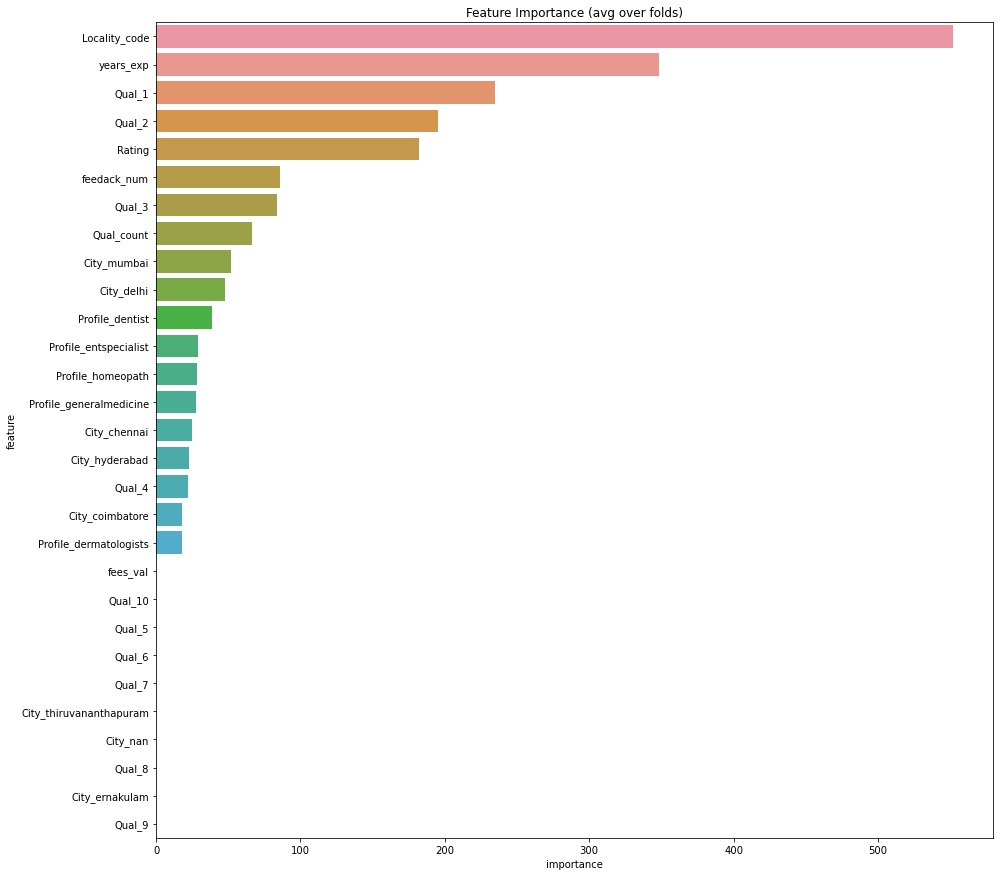

In [92]:
lgb_params = {
    'metric': 'rmse',
    "objective" : "regression",
    'min_data_in_leaf': 149, 
    'max_depth': 9,
    "boosting": "gbdt",
    "lambda_l1": 0.2634,
    "random_state": 133,
    "num_leaves" : 30,
    "min_child_samples" : 100,
    "learning_rate" : 0.1,
    "bagging_fraction" : 0.7,
    "feature_fraction" : 0.5,
    "bagging_frequency" : 5,
    "bagging_seed" : 4,
    "verbosity" : -1
    }

result_dict_lgb = train_model(X=train_X,
                              X_test=test_X,
                              y=train_y,
                              params=lgb_params,
                              model_type='lgb',
                              plot_feature_importance=True,
                              make_oof=True,
                              num_class=0                           
                             )


In [103]:
test_lgb = test_df[['Qualification', 'Experience', 'Rating', 'Place', 'Profile','Miscellaneous_Info']].copy()
test_lgb['Fees'] = result_dict_lgb['prediction']

In [108]:
# Create X and Y dataset

Y = train_y.copy()
X = train[cols_to_use]

In [110]:
!pip install keras

In [112]:
!pip install TensorFlow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4835 sha256=3c08b9cd00c39e9d193359844125116c826e02b62b650d37dace3f71d0f06cf5
  Stored in directory: c:\users\vinay\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
  Created wheel for wrapt: filename=wrapt-1.12.1-py3-none-any.whl size=19558 sha256=2b26e476301ccae757b17e3ee88ffcadd9da9f4dc79febd6d12cf113fea07484
  Stored in directory: c:\users\vinay\appdata\local\pip\cache\wheels\5f\fd\9e\b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73
Successfully built termcolor wrapt
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.11.2
    Uninstalling wrapt-1.11.2:
      Successfully uninstalled wrapt-1.11.2


In [113]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

# Function to create model
def baseline_model(learn_rate=0.01, init_mode='normal', activation = 'relu', dropout_rate=0.1, weight_constraint=1, neurons = 100):
    model = Sequential()
    model.add(Dense(units = neurons, kernel_initializer = init_mode, activation = activation, input_dim = 29))
    model.add(BatchNormalization())
#     model.add(Dropout(rate = dropout_rate))
    model.add(Dense(units = int(neurons / 2), kernel_initializer = init_mode, activation = activation))
#     model.add(Dropout(rate = dropout_rate))
    model.add(Dense(units = int(neurons / 4), kernel_initializer = init_mode, activation = activation))
#     model.add(Dropout(rate = dropout_rate))
    model.add(Dense(units = 1, kernel_initializer = init_mode, activation = 'linear'))
    optimizer = Adam(lr=learn_rate)
    model.compile(optimizer = optimizer, loss = 'mean_squared_logarithmic_error', metrics = ['mse'])
    return model

# fix random seed for reproducibility
seed = 4
np.random.seed(seed)

In [114]:
from keras.callbacks import ModelCheckpoint

checkpoint_name = 'weights.best.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

# Train the model
model = baseline_model()
model.summary()
model.fit(X, Y, epochs=100, batch_size=58, validation_split = 0.2, callbacks=callbacks_list)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               3000      
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 9,751
Trainable params: 9,551
Non-trainable params: 200
_________________________________________________________________
Epoch 1/100
83/83 [==============================] - 3s 22ms/step - loss: 9.6328 - mse: 90556.9707 - val_loss: 0.5213 


Epoch 00035: val_loss did not improve from 0.38222
Epoch 36/100
83/83 [==============================] - 0s 4ms/step - loss: 0.3743 - mse: 31859.5397 - val_loss: 0.4188 - val_mse: 30460.0293

Epoch 00036: val_loss did not improve from 0.38222
Epoch 37/100
83/83 [==============================] - 0s 4ms/step - loss: 0.3806 - mse: 32424.5898 - val_loss: 0.3852 - val_mse: 33902.3086

Epoch 00037: val_loss did not improve from 0.38222
Epoch 38/100
83/83 [==============================] - 0s 4ms/step - loss: 0.3759 - mse: 32781.7147 - val_loss: 0.3834 - val_mse: 32565.1074

Epoch 00038: val_loss did not improve from 0.38222
Epoch 39/100
83/83 [==============================] - 0s 3ms/step - loss: 0.3886 - mse: 34693.3126 - val_loss: 0.3882 - val_mse: 32652.6973

Epoch 00039: val_loss did not improve from 0.38222
Epoch 40/100
83/83 [==============================] - 0s 3ms/step - loss: 0.3710 - mse: 32802.3515 - val_loss: 0.3870 - val_mse: 33692.7812

Epoch 00040: val_loss did not improve f

83/83 [==============================] - 0s 3ms/step - loss: 0.3576 - mse: 31660.8709 - val_loss: 0.3866 - val_mse: 35030.2617

Epoch 00078: val_loss did not improve from 0.37888
Epoch 79/100
83/83 [==============================] - 0s 3ms/step - loss: 0.3608 - mse: 31334.8862 - val_loss: 0.3935 - val_mse: 32517.2715

Epoch 00079: val_loss did not improve from 0.37888
Epoch 80/100
83/83 [==============================] - 0s 4ms/step - loss: 0.3513 - mse: 31477.1999 - val_loss: 0.3866 - val_mse: 31180.1816

Epoch 00080: val_loss did not improve from 0.37888
Epoch 81/100
83/83 [==============================] - 0s 4ms/step - loss: 0.3696 - mse: 31206.4695 - val_loss: 0.4049 - val_mse: 37011.5547

Epoch 00081: val_loss did not improve from 0.37888
Epoch 82/100
83/83 [==============================] - 0s 4ms/step - loss: 0.3662 - mse: 31647.7295 - val_loss: 0.3803 - val_mse: 32647.7148

Epoch 00082: val_loss did not improve from 0.37888
Epoch 83/100
83/83 [==============================] -

In [115]:
weights_file = checkpoint_name # choose the best checkpoint 
model.load_weights(weights_file) # load it
model.compile(loss='mean_absolute_error', optimizer=Adam(lr=0.01), metrics=['mean_absolute_error'])

In [116]:
# Predictions
pred_dnn = model.predict(test[cols_to_use])

In [117]:
# Create submission
test_dnn = test_df[['Qualification', 'Experience', 'Rating', 'Place', 'Profile','Miscellaneous_Info']].copy()
test_dnn['Fees'] = pred_dnn

Let's default mark the Fees value as 100 for the selected records as decided

In [123]:
test_lgb = mark_100(test_lgb.copy())



In [124]:
test_lgb.to_csv('submission_lgb.csv', index=False)